# Installations & Setup

In [ ]:
! pip install -q kaggle
! pip install torchmetrics --quiet
! pip install detoxify

  Using cached detoxify-0.5.2-py3-none-any.whl.metadata (13 kB)


In [ ]:
import os
import csv
import json
import torch
import pickle
import random
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from detoxify import Detoxify
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchmetrics import AUROC, F1Score
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from google.colab import drive, userdata, files
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Set seeds for reproducability
torch.manual_seed(0)

In [ ]:
# Get Kaggle keys to download data
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# Download data from Kaggle competition
! kaggle competitions download -c toxic-comment-classification-dsba-2025
! unzip "toxic-comment-classification-dsba-2025.zip"

 96% 63.0M/65.9M [00:03<00:00, 27.5MB/s]
100% 65.9M/65.9M [00:03<00:00, 20.7MB/s]
Archive:  toxic-comment-classification-dsba-2025.zip
  inflating: kaggle_baseline.ipynb   
  inflating: kaggle_data/test_x.csv  
  inflating: kaggle_data/train_x.csv  
  inflating: kaggle_data/train_y.csv  
  inflating: kaggle_data/val_x.csv   
  inflating: kaggle_data/val_y.csv   


In [ ]:
# /////////// Import for Francesco ///////////
files.upload()

# Move kaggle.json to the correct location
with open("kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)
os.environ["KAGGLE_USERNAME"] = kaggle_credentials["username"]
os.environ["KAGGLE_KEY"] = kaggle_credentials["key"]

# Make sure the Kaggle folder exists
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c toxic-comment-classification-dsba-2025
!unzip toxic-comment-classification-dsba-2025.zip

Saving kaggle.json to kaggle.json
 97% 64.0M/65.9M [00:04<00:00, 20.6MB/s]
100% 65.9M/65.9M [00:04<00:00, 15.4MB/s]
Archive:  toxic-comment-classification-dsba-2025.zip
  inflating: kaggle_baseline.ipynb   
  inflating: kaggle_data/test_x.csv  
  inflating: kaggle_data/train_x.csv  
  inflating: kaggle_data/train_y.csv  
  inflating: kaggle_data/val_x.csv   
  inflating: kaggle_data/val_y.csv   


In [ ]:
# Transform data to dataframes
train_x = pd.read_csv('kaggle_data/train_x.csv')
train_y = pd.read_csv('kaggle_data/train_y.csv')
val_x = pd.read_csv('kaggle_data/val_x.csv')
val_y = pd.read_csv('kaggle_data/val_y.csv')
test_x = pd.read_csv('kaggle_data/test_x.csv')

# Set the list of subpopulations
subpopulations = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set directory
data_dir = 'kaggle_data'

# Data Exploration

## Overall

In [ ]:
train_x.head()

,index,string
0,0,even up here.......BLACKS!
1,1,Blame men. There's always an excuse to blame ...
2,2,You have no business making any comments on th...
3,3,"""Let's get the black folks and the white folks..."
4,4,I guess the issue is people not willing to put...


In [ ]:
train_x.shape, val_x.shape

((269038, 2), (45180, 2))

In [ ]:
train_y.head()

,male,female,LGBTQ,christian,muslim,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,y,from_source_domain
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1
1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [ ]:
# Check data shapes and column names
print("Train X Shape:", train_x.shape)
print("Train Y Shape:", train_y.shape)
print("\nTrain X Columns:\n", train_x.columns)
print("\nTrain Y Columns:\n", train_y.columns)

Train X Shape: (269038, 2)
Train Y Shape: (269038, 17)

Train X Columns:
 Index(['index', 'string'], dtype='object')

Train Y Columns:
 Index(['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions',
       'black', 'white', 'identity_any', 'severe_toxicity', 'obscene',
       'threat', 'insult', 'identity_attack', 'sexual_explicit', 'y',
       'from_source_domain'],
      dtype='object')


train and val have the same shapes, which is good.

--> **Potential idea**: merge train and val, and then do a k-fold training for better results



### Check for NA values

In [ ]:
empty_comments_x = train_x[(train_x['string'] == '') | (train_x['string'].isnull())]
print(empty_comments_x.head())
# Check for missing values
print("Missing values in Train X:\n", train_x.isnull().sum())
print("Missing values in Train Y:\n", train_y.isnull().sum())

         index string
141037  141037    NaN
Missing values in Train X:
 index     0
string    1
dtype: int64
Missing values in Train Y:
 male                  0
female                0
LGBTQ                 0
christian             0
muslim                0
other_religions       0
black                 0
white                 0
identity_any          0
severe_toxicity       0
obscene               0
threat                0
insult                0
identity_attack       0
sexual_explicit       0
y                     0
from_source_domain    0
dtype: int64


We have only 1 empty comment in train_x and no empty cell in train_y, so we **need to drop this index in both train_x and train_y** as it cannot be imputed and it is just one observation out of 269038 so irrelevant towards final result






In [ ]:
# Checking for rows in train_y where no labels are occurring
not_filled_y = train_y[train_y.sum(axis=1) == 0]
not_filled_y.shape

(0, 17)

0 rows where the row has not be labeled, which is good for us, we can proceed further as there is the confirmation of not having missing values

In [ ]:
# This checks for rows in train_y where no labels are assigned (sum of the row equals 0).
not_filled_y = train_y[train_y[subpopulations].sum(axis=1) == 0]
not_filled_y.shape

(160917, 17)

161k rows where the row has not be labeled to any subpopulation. We may need to **be careful about that.**
These rows indeed represent more than 50% of the overall training data and they add a large amount of "generic" non-toxic data to the dataset, making less relevant the signal from the toxic comments in relation to the specific subpopulations.
This imbalance makes it harder for us to understand the relationships between toxicity and the subpopulation.

**Additional consideration towards the final result** Since the evaluation metric focuses on worst-group accuracy (small subpopulations), the inclusion of these rows could lead to poor performance on minority subpopulations, as the model may prioritize overall accuracy instead. Therefore we might think about deleting these rows rather than imputing them.


### Check for unbalanceness on the entire dataset

Count of toxic     comments: 30515 
Count of non-toxic comments: 238523


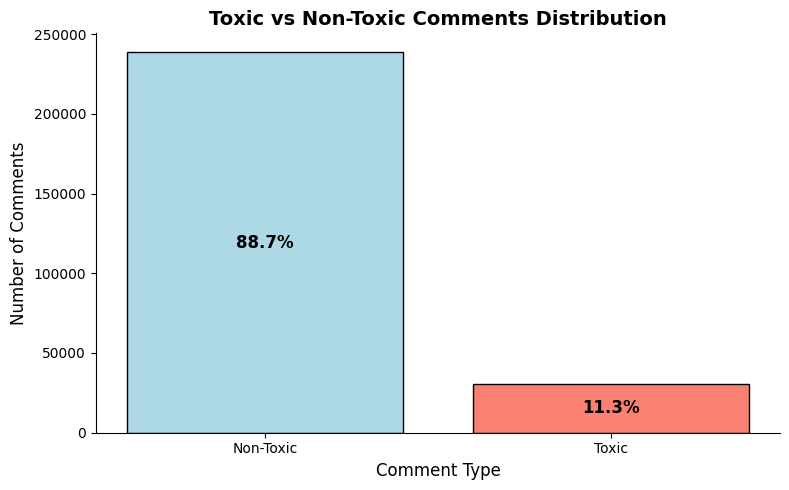

In [ ]:
# Counting the total number of toxic and non-toxic comments
toxic_count = train_y[train_y["y"]==1].shape[0]
non_toxic_count = train_y[train_y["y"]==0].shape[0]
total = toxic_count + non_toxic_count
print(f'Count of toxic     comments: {toxic_count} \nCount of non-toxic comments: {non_toxic_count}')

# Prepare data for the plot
categories = ['Non-Toxic', 'Toxic']
counts = [non_toxic_count, toxic_count]
percentages = [count / total * 100 for count in counts]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(categories, counts, color=['lightblue', 'salmon'], edgecolor='black')

# Add annotations
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{percent:.1f}%",
            ha='center', va='center', fontsize=12, color='black', weight='bold')

# Customize the plot
ax.set_title('Toxic vs Non-Toxic Comments Distribution', fontsize=14, weight='bold')
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_xlabel('Comment Type', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

Unbalanced training set !! **We need to deal with this**. An imbalance like this one can lead to the model being biased toward predicting comments as non-toxic given that it is by far the dominating class.



## Check for Unbalancedness within each subpopulation

Let's visualize the disparities between toxic and not-toxic whithin subpopulations



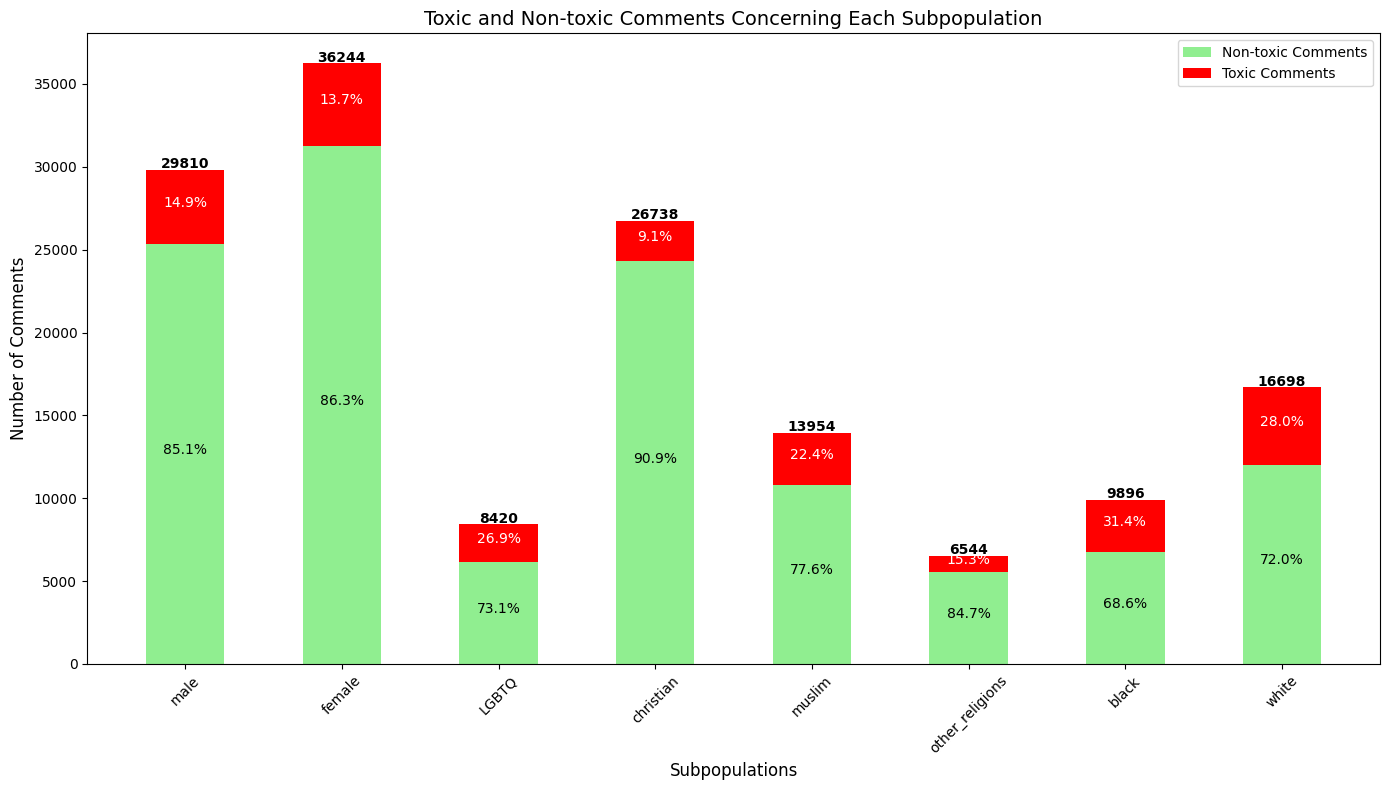

In [ ]:
# Lists to store counts for toxic and non-toxic comments
toxic_counts = []
non_toxic_counts = []

# Calculate the counts for each subpopulation
for sub in subpopulations:
    toxic_count = train_y[(train_y[sub] == 1) & (train_y['y'] == 1)][sub].count()
    non_toxic_count = train_y[(train_y[sub] == 1) & (train_y['y'] == 0)][sub].count()
    toxic_counts.append(toxic_count)
    non_toxic_counts.append(non_toxic_count)

# Convert to numpy arrays for stacking
toxic_counts = np.array(toxic_counts)
non_toxic_counts = np.array(non_toxic_counts)
total_counts = toxic_counts + non_toxic_counts
toxic_percentages = (toxic_counts / total_counts) * 100
non_toxic_percentages = (non_toxic_counts / total_counts) * 100

# Plot a stacked bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.5

# Bars for non-toxic comments
bars_non_toxic = plt.bar(subpopulations, non_toxic_counts, label='Non-toxic Comments', color='lightgreen', width=bar_width)

# Bars for toxic comments (stacked on top of non-toxic)
bars_toxic = plt.bar(subpopulations, toxic_counts, label='Toxic Comments', color='red', bottom=non_toxic_counts, width=bar_width)

# Add totals and percentages to the bars
for i, (toxic, non_toxic, total, toxic_pct, non_toxic_pct) in enumerate(
    zip(toxic_counts, non_toxic_counts, total_counts, toxic_percentages, non_toxic_percentages)):
    # Add total count
    plt.text(i, total + 100, f"{total}", ha='center', fontsize=10, fontweight='bold', color='black')
    # Add toxic percentage
    plt.text(i, non_toxic + toxic / 2, f"{toxic_pct:.1f}%", ha='center', fontsize=10, color='white')
    # Add non-toxic percentage
    plt.text(i, non_toxic / 2, f"{non_toxic_pct:.1f}%", ha='center', fontsize=10, color='black')

# Add labels, title, and legend
plt.xlabel("Subpopulations", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Toxic and Non-toxic Comments Concerning Each Subpopulation", fontsize=14)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
plt.legend(fontsize=10)
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

Same here, dataset is unbalanced within the different subpopulations concerning number of comments and number of toxic versus non-toxic comments. **This is a huge leverage of bias, we need to fix this.**
Some subpopulations, like LGBTQ and Black, exhibit higher proportions of toxic comments compared to others, but they show at the same time a lower number of observations, which makes them harder to be predicted.
Other subpopulations, such as Christian and Other Religions, show relatively lower percentages of toxic comments.

# Data Cleaning

## Handle NA values

In [ ]:
# Get NA row indexes:
empty_comments_train = train_x[(train_x['string'] == '') | (train_x['string'].isnull())]
empty_comments_val = val_x[(val_x['string'] == '') | (val_x['string'].isnull())]
empty_comments_test = test_x[(test_x['string'] == '') | (test_x['string'].isnull())]

# Drop NA rows
train_x, train_y = train_x.drop(empty_comments_train.index), train_y.drop(empty_comments_train.index)
val_x, val_y = val_x.drop(empty_comments_val.index), val_y.drop(empty_comments_val.index)
print('Dropped:')
print(empty_comments_train.shape[0],'Train NAs')
print(empty_comments_val.shape[0],'Val NAs')

# Fill NAs for Testing dataset
index = empty_comments_test.index[0]
test_x.loc[index, 'string'] = ' '
print('Filled:')
print(empty_comments_test.shape[0],'Test NAs')

# Save the cleaning
train_x.to_csv('kaggle_data/train_x.csv', index=False)
train_y.to_csv('kaggle_data/train_y.csv', index=False)
val_x.to_csv('kaggle_data/val_x.csv', index=False)
val_y.to_csv('kaggle_data/val_y.csv', index=False)
test_x.to_csv('kaggle_data/test_x.csv', index=False)

Dropped:
1 Train NAs
0 Val NAs
Filled:
1 Test NAs


## Balance dataset

### Strategies

There are multiple strategies to balance our dataset and ensure fairness, including:

- Oversampling
- Downsampling
- Balance y=0 and y=1
- Balance subpopulations

Each choice of method can introduce bias, redundancy, loss of information, increased computational constraints... We need to find a tradeoff to optimize the fairness of our results.


While balancing dataset, we need to make sure that each subpopulation is presented equally, and that toxic against non-toxic is also balanced. It is a double balancing problem.

As there are some interactions between subpopulations (for example, one comment can be toxic against male and white), it is super difficult to be exactly balanced.

However, we know based on training made later in this notebook that Black_1 and white_1 are always the worst accuracies, followed by LGBT_1 and muslim_1, other_religion_1, male_1, female_1 and christian_1.


**Option 1:** Oversampling

We can oversample using data augmentation (paraphrasing, back-translation, LLM calls...)

**Option 2:** Downsampling

We can downsample starting first by selecting x sample from black_1 and white_1, and then add samples for other subpopulations (from the worst predicted subpopulation to the best predicted). This way, we are sure that the worst subpopulation accuracies are represented enough in our new downsampled dataset, thanks to interractions (transforming a constraint into an opportunity).



### Oversampling

As a global strategy to find a correct tradeoff, we could:
1. Augment data to balance toxic/non-toxic within each subpopulation
2. Augment data to balance subpopulations, but do not reach perfect balance.
3. In training, implement a weighted loss to counter the remaining unbalance between subpopulations.

#### Transformers

Using **transformers** (like paraphrasing and back-translation) can help improving our dataset as they generate diverse variations of existing text in order to balance datasets, like the one we have, where some classes (toxic comments) are underrepresented. By helping the model learning from more examples of the minority class, there is the potential to improve generalization and fairness in imbalanced datasets.
Furthermore, models trained on augmented datasets with paraphrased or translated text encounter more linguistic patterns than the ones without, thus, this can possibly mitigate sources of overfitting to the specific structure of the original data. The subsequent models might be able to better generalize to unseen comments, even if they are phrased differently from the original ones.

Here are some examples of how our transformations are supposed to work:
- **Paraphrasing:**
  - Original: "You are so stupid."
  - Paraphrased: "You're incredibly dumb."
- **Back-Translation:**
  - Original: "Stop being so rude."
  - Back-Translated (EN → FR → EN): "Don't be so impolite."


In [ ]:
! pip install transformers
! pip install sacremoses
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import MarianMTModel, MarianTokenizer

In [ ]:
# Load T5 model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base") # t5-base
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base") # t5-base

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
t5_model.to(device)

def paraphrase(text):
    # Add task prefix
    input_text = "paraphrase: " + text # + " </s>"
    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

    # Generate paraphrase
    outputs = t5_model.generate(input_ids, max_length=512, num_beams=5, num_return_sequences=1, early_stopping=True)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
# Load translation models
src_to_french = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
french_to_src = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en")

src_to_french.to(device)
french_to_src.to(device)

src_to_french_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
french_to_src_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")

# Back-translation alters sentence structure while preserving the meaning.
# This reduces the risk of the model associating toxicity with specific words or phrases due to biases in the original dataset.

def back_translate(text):
    # Translate to French
    french_input_ids = src_to_french_tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True).to(device)
    french_outputs = src_to_french.generate(french_input_ids, max_length=512, num_beams=5, early_stopping=True)
    french_text = src_to_french_tokenizer.decode(french_outputs[0], skip_special_tokens=True)

    # Translate back to English
    src_input_ids = french_to_src_tokenizer.encode(french_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    src_outputs = french_to_src.generate(src_input_ids, max_length=512, num_beams=5, early_stopping=True)
    return french_to_src_tokenizer.decode(src_outputs[0], skip_special_tokens=True)


In [ ]:
# Unlike traditional augmentation methods (e.g., synonym replacement or random word insertion),
# Transformers produce natural language outputs that are contextually consistent with the input.

#In many datasets, there might be very few toxic comments referencing specific subpopulations.
#Augmentation using transformers helps generate more examples of these underrepresented cases.

def augment_single_text(text):
        if random.random() < 0.5:  # 50% chance of paraphrasing
            return paraphrase(text)
        else:  # 50% chance of back-translation
            return back_translate(text)

#### EDA

Our Easy Data Augmentation pipeline is denoted by two main components: **synonym replacement** and **noise injection**.

Synonym Replacement replaces up to n random words in a sentence with their synonyms using the WordNet lexical database without drastically changing the sentence's meaning. It consist of a lightweight version than the transformers one. Sometimes, however, its synonyms may not always fit the context. Noise Injection instead introduces random noise into the sentence by replacing or inserting random characters with the aim of mimicking human typos and spelling errors os that the model more can be more robust to noisy inputs.

In [ ]:
# Synonym Replacement

def synonym_replacement(sentence, n=1):
    """
    Replace up to n random words in the sentence with their synonyms.
    """
    words = sentence.split()
    if len(words) < 2:
        return sentence

    # Find words with valid synonyms
    candidate_words = [(word, wordnet.synsets(word)) for word in words if wordnet.synsets(word)]
    if not candidate_words:
        return sentence

    # Randomly select words to replace
    words_to_replace = random.sample(candidate_words, n)

    for word, synsets in words_to_replace:
        synonym = random.choice(synsets).lemmas()[0].name()
        if synonym != word:
            words = [synonym if w == word else w for w in words]

    return " ".join(words)

# Noise Injection
def noise_injection(sentence, n=1):
    """
    Introduce random character noise in the sentence by replacing or inserting characters.
    """
    if not sentence:
        return sentence

    words = list(sentence)
    for _ in range(min(n, len(words))):
        idx = random.randint(0, len(words) - 1)
        if random.random() < 0.5:  # 50% chance to replace
            words[idx] = chr(random.randint(97, 122))
        else:  # 50% chance to insert
            words.insert(idx, chr(random.randint(97, 122)))

    return "".join(words)

# Combined EDA
def eda_augmentation(sentence, synonym_replacements=1, noise_injections=1):
    augmented_sentence = synonym_replacement(sentence, synonym_replacements)
    return noise_injection(augmented_sentence, noise_injections)


#### Toxic/Non-toxic balance within subpopulations

For this part of the analysis we are solely focusing on the data which has some subpopulation index, leaving on the side the 160.000 observation which apparently are not referred to any subpopulation in particular.

In [ ]:
# Filter the data to include only comments associated with at least one subpopulation
subpopulation_presence = train_y[subpopulations].sum(axis=1) > 0
filtered_train_x = train_x[subpopulation_presence]
filtered_train_y = train_y[subpopulation_presence]

# Count toxic and non-toxic comments within the filtered data
toxic_count = filtered_train_y[filtered_train_y["y"] == 1].shape[0]
non_toxic_count = filtered_train_y[filtered_train_y["y"] == 0].shape[0]
total_count = toxic_count + non_toxic_count

# Calculate percentages
toxic_percentage = toxic_count / total_count * 100
non_toxic_percentage = non_toxic_count / total_count * 100

# Prepare data for the plot
categories = ['Non-Toxic', 'Toxic']
counts = [non_toxic_count, toxic_count]
percentages = [non_toxic_percentage, toxic_percentage]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(categories, counts, color=['lightblue', 'salmon'], edgecolor='black')

# Add annotations
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{percent:.1f}%",
            ha='center', va='center', fontsize=12, color='black', weight='bold')

# Customize the plot
ax.set_title('Toxic vs Non-Toxic Comments (With Subpopulation)', fontsize=14, weight='bold')
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_xlabel('Comment Type', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Balance toxic/non-toxic within each subpopulation
balanced_train_x, balanced_train_y = [], []

for sub in subpopulations:
    print('--> Working with sub:', sub)
    # Separate toxic and non-toxic for the subpopulation
    toxic = train_x[(train_y[sub] == 1) & (train_y['y'] == 1)]
    non_toxic = train_x[(train_y[sub] == 1) & (train_y['y'] == 0)]

    toxic_y = train_y[(train_y[sub] == 1) & (train_y['y'] == 1)]
    non_toxic_y = train_y[(train_y[sub] == 1) & (train_y['y'] == 0)]


    # Oversample the minority class
    if len(toxic) < len(non_toxic):
        # Resample to get match majority class
        toxic_aug = resample(toxic, replace=True, n_samples=len(non_toxic) - len(toxic), random_state=42)
        toxic_y_aug = resample(toxic_y, replace=True, n_samples=len(non_toxic) - len(toxic), random_state=42)

        # Augment resampled comments
        toxic_aug['string'] = toxic_aug['string'].apply(lambda x: eda_augmentation(x))

        # Check the shapes after augmentation
        print(f"Toxic data shapes: {toxic_aug.shape}, {toxic_y_aug.shape}")
        print(f"Non-toxic data shapes: {non_toxic.shape}, {non_toxic_y.shape}")

        toxic = pd.concat([toxic, toxic_aug])
        toxic_y = pd.concat([toxic_y, toxic_y_aug])


    else:
        # Resample
        non_toxic_aug = resample(non_toxic, replace=True, n_samples=len(toxic) - len(non_toxic), random_state=42)
        non_toxic_y_aug = resample(non_toxic_y, replace=True, n_samples=len(toxic) - len(non_toxic), random_state=42)

        # Augment comment
        non_toxic_aug['string'] = non_toxic_aug['string'].apply(eda_augmentation)

        non_toxic = pd.concat([non_toxic, non_toxic_aug])
        non_toxic_y = pd.concat([non_toxic_y, non_toxic_y_aug])


    # Combine balanced toxic and non-toxic samples
    balanced_train_x.append(pd.concat([toxic, non_toxic]))
    balanced_train_y.append(pd.concat([toxic_y, non_toxic_y]))



# Combine all subpopulations
balanced_train_x = pd.concat(balanced_train_x).reset_index(drop=True)
balanced_train_y = pd.concat(balanced_train_y).reset_index(drop=True)

In [ ]:
print(f'Raw datasets have the same shape[0] : {train_x.shape[0] == train_y.shape[0]}')
print(f'New balanced datasets have the same shape[0] : {balanced_train_x.shape[0] == balanced_train_y.shape[0]}')
balanced_train_x.to_csv('kaggle_data/balanced_train_x.csv', index=False)
balanced_train_y.to_csv('kaggle_data/balanced_train_y.csv', index=False)
print('New datasets saved to folder')

In [ ]:
# VISUALIZE INTERMEDIATE RESULTS

# Lists to store counts for toxic and non-toxic comments
toxic_counts = []
non_toxic_counts = []

# Calculate the counts for each subpopulation
for sub in subpopulations:
    toxic_count = balanced_train_y[(balanced_train_y[sub] == 1) & (balanced_train_y['y'] == 1)][sub].count()
    non_toxic_count = balanced_train_y[(balanced_train_y[sub] == 1) & (balanced_train_y['y'] == 0)][sub].count()
    toxic_counts.append(toxic_count)
    non_toxic_counts.append(non_toxic_count)

# Convert to numpy arrays for stacking
toxic_counts = np.array(toxic_counts)
non_toxic_counts = np.array(non_toxic_counts)

# Calculate total counts and percentages
total_counts = toxic_counts + non_toxic_counts
toxic_percentages = (toxic_counts / total_counts) * 100
non_toxic_percentages = (non_toxic_counts / total_counts) * 100

# Plot a stacked bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.5

# Bars for non-toxic comments
bars_non_toxic = plt.bar(
    subpopulations, non_toxic_counts, label='Non-toxic Comments', color='lightgreen', width=bar_width
)

# Bars for toxic comments (stacked on top of non-toxic)
bars_toxic = plt.bar(
    subpopulations, toxic_counts, label='Toxic Comments', color='red', bottom=non_toxic_counts, width=bar_width
)

# Add annotations (totals and percentages)
for i, (toxic, non_toxic, total, toxic_pct, non_toxic_pct) in enumerate(
    zip(toxic_counts, non_toxic_counts, total_counts, toxic_percentages, non_toxic_percentages)
):
    # Add total count above the bar
    plt.text(i, total + 200, f"{total}", ha='center', fontsize=10, fontweight='bold', color='black')
    # Add toxic percentage inside the red section
    plt.text(i, non_toxic + toxic / 2, f"{toxic_pct:.1f}%", ha='center', fontsize=10, color='white')
    # Add non-toxic percentage inside the green section
    plt.text(i, non_toxic / 2, f"{non_toxic_pct:.1f}%", ha='center', fontsize=10, color='black')

# Add labels, title, and legend
plt.xlabel("Subpopulations", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Toxic and Non-toxic Comments Concerning Each Subpopulation", fontsize=14)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
plt.legend(fontsize=10)
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

It seems that toxic/non-toxic is not fairly balanced within each subpopulation.

Let's now balances between populations.

#### Subpopulation balance

In [ ]:
# Step 2: Balance subpopulations (partial balance)
# Calculate the maximum target count for all subpopulations
target_count = []
for sub in subpopulations:
    count = balanced_train_y[balanced_train_y[sub] == 1].shape[0]
    target_count.append(count)

print(f"Counts for each subpopulation before balancing: {target_count}")

# Set target count to 75% of the majority subpopulation
target_count = int(max(target_count) * 0.75)
print(f"Target count for balancing: {target_count}")

final_train_x, final_train_y = [], []

# Balance each subpopulation
for sub in subpopulations:
    print(f'--> Balancing subpopulation: {sub}')

    # Filter data for the current subpopulation
    subpop_x = balanced_train_x[balanced_train_y[sub] == 1]
    subpop_y = balanced_train_y[balanced_train_y[sub] == 1]

    # Check if resampling is needed
    if subpop_x.shape[0] >= target_count:
        # Skip resampling for already balanced subpopulations
        print(f'   {sub} is already balanced: {subpop_x.shape[0]} >= {target_count}')
        final_train_x.append(subpop_x)
        final_train_y.append(subpop_y)
        continue  # Skip to the next subpopulation

    print(f'   {sub} needs resampling: {subpop_x.shape[0]} < {target_count}')

    # Resample to reach target count
    subpop_aug_x = resample(
        subpop_x, replace=True, n_samples=target_count - subpop_x.shape[0], random_state=42
    )
    subpop_aug_y = resample(
        subpop_y, replace=True, n_samples=target_count - subpop_y.shape[0], random_state=42
    )

    # Apply EDA to the resampled data
    subpop_aug_x['string'] = subpop_aug_x['string'].apply(eda_augmentation)

    # Combine original and augmented data
    subpop_x = pd.concat([subpop_x, subpop_aug_x]).reset_index(drop=True)
    subpop_y = pd.concat([subpop_y, subpop_aug_y]).reset_index(drop=True)

    print(f'   Final shape for {sub}: {subpop_x.shape}, {subpop_y.shape}')

    # Append balanced data for this subpopulation
    final_train_x.append(subpop_x)
    final_train_y.append(subpop_y)

# Combine balanced data for all subpopulations
final_train_x = pd.concat(final_train_x).reset_index(drop=True)
final_train_y = pd.concat(final_train_y).reset_index(drop=True)

# Verify the final counts for each subpopulation
final_counts = []
for sub in subpopulations:
    final_counts.append(final_train_y[final_train_y[sub] == 1].shape[0])
print(f"Counts for each subpopulation after balancing: {final_counts}")

In [ ]:
# VISUALIZE FINAL RESULTS

# Lists to store counts for toxic and non-toxic comments
toxic_counts = []
non_toxic_counts = []

# Calculate the counts for each subpopulation
for sub in subpopulations:
    toxic_count = final_train_y[(final_train_y[sub] == 1) & (final_train_y['y'] == 1)][sub].count()
    non_toxic_count = final_train_y[(final_train_y[sub] == 1) & (final_train_y['y'] == 0)][sub].count()
    toxic_counts.append(toxic_count)
    non_toxic_counts.append(non_toxic_count)

# Convert to numpy arrays for stacking
toxic_counts = np.array(toxic_counts)
non_toxic_counts = np.array(non_toxic_counts)

# Calculate total counts and percentages
total_counts = toxic_counts + non_toxic_counts
toxic_percentages = (toxic_counts / total_counts) * 100
non_toxic_percentages = (non_toxic_counts / total_counts) * 100

# Plot a stacked bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.5

# Bars for non-toxic comments
bars_non_toxic = plt.bar(
    subpopulations, non_toxic_counts, label='Non-toxic Comments', color='lightgreen', width=bar_width
)

# Bars for toxic comments (stacked on top of non-toxic)
bars_toxic = plt.bar(
    subpopulations, toxic_counts, label='Toxic Comments', color='red', bottom=non_toxic_counts, width=bar_width
)

# Add annotations (totals and percentages)
for i, (toxic, non_toxic, total, toxic_pct, non_toxic_pct) in enumerate(
    zip(toxic_counts, non_toxic_counts, total_counts, toxic_percentages, non_toxic_percentages)
):
    # Add total count above the bar
    plt.text(i, total + 200, f"{total}", ha='center', fontsize=10, fontweight='bold', color='black')
    # Add toxic percentage inside the red section
    plt.text(i, non_toxic + toxic / 2, f"{toxic_pct:.1f}%", ha='center', fontsize=10, color='white')
    # Add non-toxic percentage inside the green section
    plt.text(i, non_toxic / 2, f"{non_toxic_pct:.1f}%", ha='center', fontsize=10, color='black')

# Add labels, title, and legend
plt.xlabel("Subpopulations", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Toxic and Non-toxic Comments Concerning Each Subpopulation", fontsize=14)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for better readability
plt.legend(fontsize=10)
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

--> We balanced data between categories, which is nice. However, we can notice that all the categories increased, even the majority ones. This may due to the fact that some comments from minority are also for majority.

--> **May not be worth it** to balance between subpopulations as the goal is not reached completely, and it may introduce overfitting or poorer performances. Instead, we should use a weighted loss function, or fairness loss function, so that the model is not biased toward over-represented subpopulations.

In [ ]:
# Merging the oversampled dataset with the other data which did not have any information regarding subpopulation

# Step 1: Filter rows without any subpopulation reference
non_subpopulation_mask = train_y[subpopulations].sum(axis=1) == 0
non_subpopulation_x = train_x[non_subpopulation_mask].reset_index(drop=True)
non_subpopulation_y = train_y[non_subpopulation_mask].reset_index(drop=True)

print(f"Non-subpopulation data shape: {non_subpopulation_x.shape}, {non_subpopulation_y.shape}")

# Step 2: Combine the oversampled and non-subpopulation data
merged_train_x = pd.concat([final_train_x, non_subpopulation_x], axis=0).reset_index(drop=True)
merged_train_y = pd.concat([final_train_y, non_subpopulation_y], axis=0).reset_index(drop=True)

# Step 3: Verify the merged dataset
print(f"Merged dataset shape: {merged_train_x.shape}, {merged_train_y.shape}")

# Optional: Save the merged dataset
merged_train_x.to_csv('merged_train_x.csv', index=False)
merged_train_y.to_csv('merged_train_y.csv', index=False)

print("Merged dataset saved successfully.")

In [ ]:
# Step 1: Print general dataset information
print("Merged Dataset Overview:")
print(f"Total number of comments: {merged_train_x.shape[0]}")
print(f"Number of features in X: {merged_train_x.shape[1]}")
print(f"Number of labels in Y: {merged_train_y.shape[1]}")

# Step 2: Check the distribution of toxic vs non-toxic comments
toxic_count = merged_train_y[merged_train_y["y"] == 1].shape[0]
non_toxic_count = merged_train_y[merged_train_y["y"] == 0].shape[0]
total_count = toxic_count + non_toxic_count

# Print counts and percentages
print("\nToxic vs Non-Toxic Distribution:")
print(f"Toxic Comments: {toxic_count} ({toxic_count / total_count * 100:.2f}%)")
print(f"Non-Toxic Comments: {non_toxic_count} ({non_toxic_count / total_count * 100:.2f}%)")

# Step 3: Distribution of subpopulation presence
subpopulation_presence = merged_train_y[subpopulations].sum(axis=1) > 0
with_subpopulation = subpopulation_presence.sum()
without_subpopulation = (~subpopulation_presence).sum()

print("\nSubpopulation Presence Distribution:")
print(f"Comments with subpopulation references: {with_subpopulation} ({with_subpopulation / total_count * 100:.2f}%)")
print(f"Comments without subpopulation references: {without_subpopulation} ({without_subpopulation / total_count * 100:.2f}%)")

# Step 4: Visualization of Toxic vs Non-Toxic Comments
categories = ['Non-Toxic', 'Toxic']
counts = [non_toxic_count, toxic_count]
percentages = [non_toxic_count / total_count * 100, toxic_count / total_count * 100]

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(categories, counts, color=['lightblue', 'salmon'], edgecolor='black')

# Annotate bars with percentages
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{percent:.1f}%",
            ha='center', va='center', fontsize=12, color='black', weight='bold')

# Customize the plot
ax.set_title('Toxic vs Non-Toxic Comments Distribution', fontsize=14, weight='bold')
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_xlabel('Comment Type', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Step 5: Subpopulation Presence Visualization
presence_categories = ['With Subpopulation', 'Without Subpopulation']
presence_counts = [with_subpopulation, without_subpopulation]
presence_percentages = [with_subpopulation / total_count * 100, without_subpopulation / total_count * 100]

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(presence_categories, presence_counts, color=['lightgreen', 'lightcoral'], edgecolor='black')

# Annotate bars with percentages
for bar, percent in zip(bars, presence_percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f"{percent:.1f}%",
            ha='center', va='center', fontsize=12, color='black', weight='bold')

# Customize the plot
ax.set_title('Subpopulation Presence Distribution', fontsize=14, weight='bold')
ax.set_ylabel('Number of Comments', fontsize=12)
ax.set_xlabel('Subpopulation Reference', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
print(merged_train_x.head())

In [ ]:
print(final_train_y.head())

In [ ]:
# We may have to drop NAs again after balancing !

empty_comments_x = merged_train_x[(merged_train_x['string'] == '') | (merged_train_x['string'].isnull())]
print(empty_comments_x.shape)

# Drop NA rows:
merged_train_x, merged_train_y = merged_train_x.drop(empty_comments_x.index), merged_train_y.drop(empty_comments_x.index)

# Double-check:
empty_comments = merged_train_x[(merged_train_x['string'] == '') | (merged_train_x['string'].isnull())]
print(empty_comments.shape)
print('NA successfully dropped !')

## Bonus : Multi-classes encoding

For each subpopulation, we are interested in toxic AND not toxic accuracies, to reduce bias as much as we can.

We therefore need to encode 2*8=16 target variables, which will be our 16 classes we hope to predict with our neural net.

For example:
- Black toxic, 'black' = 1 AND 'y' = 1
- Black not toxic, 'black' = 1 AND 'y' = 0

In [ ]:
train_y['black_t'] = np.where(((train_y['black']==1) & (train_y['y']==1)), 1, 0)
train_y['black_nt'] = np.where(((train_y['black']==1) & (train_y['y']==0)), 1, 0)

train_y['white_t'] = np.where(((train_y['white']==1) & (train_y['y']==1)), 1, 0)
train_y['white_nt'] = np.where(((train_y['white']==1) & (train_y['y']==0)), 1, 0)

train_y['christian_t'] = np.where(((train_y['christian']==1) & (train_y['y']==1)), 1, 0)
train_y['christian_nt'] = np.where(((train_y['christian']==1) & (train_y['y']==0)), 1, 0)

train_y['muslim_t'] = np.where(((train_y['muslim']==1) & (train_y['y']==1)), 1, 0)
train_y['muslim_nt'] = np.where(((train_y['muslim']==1) & (train_y['y']==0)), 1, 0)

train_y['other_religions_t'] = np.where(((train_y['other_religions']==1) & (train_y['y']==1)), 1, 0)
train_y['other_religions_nt'] = np.where(((train_y['other_religions']==1) & (train_y['y']==0)), 1, 0)

train_y['male_t'] = np.where(((train_y['male']==1) & (train_y['y']==1)), 1, 0)
train_y['male_nt'] = np.where(((train_y['male']==1) & (train_y['y']==0)), 1, 0)

train_y['female_t'] = np.where(((train_y['female']==1) & (train_y['y']==1)), 1, 0)
train_y['female_nt'] = np.where(((train_y['female']==1) & (train_y['y']==0)), 1, 0)

train_y['LGBTQ_t'] = np.where(((train_y['LGBTQ']==1) & (train_y['y']==1)), 1, 0)
train_y['LGBTQ_nt'] = np.where(((train_y['LGBTQ']==1) & (train_y['y']==0)), 1, 0)

In [ ]:
train_y.head()

It worked well, but we need to be careful, sometimes, a comment is about multiple subpopulations at the same time !
**How to deal with multiple classes in one comment ?**

-->One option would be to **randomly choose** one subpopulation, and set all the others to 0.

--> Another option would be to add more than 16 classes, and try to predict as well the **combined classes**.

Let's create our multi-class column based on previous results and considerations.

In [ ]:
def conditions(df):
    values = []
    for sub in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white'] :
        if (df[sub] == 1) & (df['y'] == 1):
            values.append(sub+'_t')
        elif (df[sub] == 1) & (df['y'] == 0):
            values.append(sub+'_nt')

    # No subpopulation involved
    if (df['y'] == 1) and len(values)==0:
        values.append('t')
    elif (df['y'] == 0) and len(values)==0:
        values.append('nt')

    return random.choice(values) # random strategy
    #return values # combined classes strategy

In [ ]:
train_y['target'] = train_y.apply(conditions, axis=1)
train_y[['y', 'target']].head()

In [ ]:
print(train_y['target'].value_counts())

If we use combined class strategy, we introduce a lot of bias as the target variable won't be balanced at all.

**--> This strategy is infeasible, or at least, too difficult with our current knowledge and time available. We give up on this and will prefer the downsampling/oversampling methods.**

# Deep Learning

## Strategies & architectures

Some ideas of strategies:

**Option 1 :**
One idea is to train our model with the multi-class classification (the 16 classes), save the weights, and then do a transfer-learning by training it again on binary classification (only 'y') starting with the saved weights.

--> *Analysis:* This approach is too complex and may introduce overfitting.

**Option 2 :**
Predict directly 'y', but use fairness metrics across subpopulations : metrics like subgroup accuracy, false positive rate (FPR), or false negative rate (FNR) for each subpopulation to evaluate bias.

**Option 3 :**
Use a multi-task learning framework, with y being main task, and predicting subpopulations being an auxiliary task.

**Option 4 :**
After training the binary classifier, perform post-training calibration (e.g., threshold adjustment) to balance performance across subpopulations.

--> *Analysis:* This approach is not sufficient, and comes on top of other solutions

Some ideas of architectures :

**Option 1:** RNNs with Sequence-to-Vector architecture is great for text classification.

--> *Analysis:* In practice, we can find better

**Option 2:** To classify comments, LSTM and GRU are the best method.

--> *Analysis:* improved version of RNN, let's try both. MSELoss is apparently best for those nets

**Option 3:** Multi-input model, with comment, y, subpopulation in data_loader ?

**Option 4:** Use pre-trained models

--> *Analysis:* Might lead to the best results, let's try bert, roberta for toxic comment classification


Some other ideas :

**Option 1:** For big models such as pre-trained models, it is super long to train then, making it impossible to train for several epochs with actual resources we have. To speed-up the process while reducing bias, we can downsample our train dataset.

*--> Analysis:* It will speed up the process for sure, but still lacks unbiasness, that is crucial. It needs to be coupled with other methods such as dataset balacing and fairness losses.

**Option 2:** Create a custom loss function that insists on fairness across subpopulations, using for example Weighted loss to give more weight on minority subpopulations or Focal loss for difficulty classified comments

*--> Analysis:* May be the key to this problem, and can be coupled with other methods as well.





---



## Needed functions

In [ ]:
# CAREFUL !!!
# If I am not mistaken, thus function should NOT be modified, as it compute the worst group accuracy, which is the constraint the competition gives us.

def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
            print(f'Accuracy for {category} {label}:', group_accuracy)
    wga = np.min(accuracies)
    return wga

In [ ]:
def compute_initial_group_weights(metadata, y):
    """
    Initialize all group weights to 1.0 to ensure a fair starting point.
    """
    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    group_weights = {(category, label): 1.0 for category in categories for label in [0, 1]}

    print("Initial Equal Group Weights:", group_weights)
    return group_weights

def compute_dynamic_group_weights(metadata, output, y, prev_group_weights, min_weight=1.0, max_weight=5.0, alpha=2, beta=0.5, decay_factor=0.85, target_weight_sum=16.0):
    # Move `y` to the same device as `output`
    device = output.device
    y = torch.tensor(y.values, device=device) if isinstance(y, pd.Series) else y

    # Convert `metadata` to tensors and move to device
    metadata = {key: torch.tensor(value.values, device=device) if isinstance(value, pd.Series) else value.to(device)
                for key, value in metadata.items()}

    # Step 1: Compute per-group accuracy
    inv_accuracies = {}
    for category in metadata:
        for label in [0, 1]:
            group_mask = metadata[category] == label  # Create mask for group
            group_output = output[group_mask]
            group_labels = y[group_mask]

            if group_mask.sum() > 0:  # Only compute if group is non-empty
                # Compute inverse group accuracy
                inv_group_accuracy = (group_labels == (torch.sigmoid(group_output) > 0.5)).float().mean().item()
                inv_accuracies[(category, label)] = inv_group_accuracy

    # Step 2: Update weights based on performance
    group_weights = {}
    total_weight = 0.0
    for (category, label), inv_accuracy in inv_accuracies.items():
        weight_update = prev_group_weights.get((category, label), 1.0)

        # Adjust weight
        if inv_accuracy > 0.15:
            weight_update += np.exp(inv_accuracy * alpha)
        else:
            weight_update -= np.log(1 + beta * inv_accuracy)

        # Clip weights
        weight_update = max(min_weight, min(weight_update, max_weight))
        group_weights[(category, label)] = weight_update
        total_weight += weight_update

    # Normalize weights to target sum
    normalization_factor = target_weight_sum / total_weight
    for group in group_weights:
        group_weights[group] *= normalization_factor

    return group_weights

def fairness_loss(pred, y, metadata, group_weights, base_loss_fn=torch.nn.BCEWithLogitsLoss(), gamma=2.5, fairness_alpha=0.6, epoch=1):
    """
    Fairness loss that **directly improves WGA** by:
    - **Applying exponential penalties to the worst groups.**
    - **Ensuring fairness grows stronger dynamically** over epochs.
    - **Boosting fairness influence only when needed.**
    """
    total_loss = 0.0
    total_weight = 0.0
    group_losses = []

    for (category, label), weight in group_weights.items():
        group_mask = (metadata[category] == label).to(pred.device)
        if group_mask.any():
            group_pred = pred[group_mask]
            group_y = y[group_mask]

            # Compute base loss for this group
            group_loss = base_loss_fn(group_pred, group_y)

            # **Power scaling to emphasize fairness impact**
            adjusted_weight = np.log1p(weight) ** gamma
            weighted_loss = group_loss * adjusted_weight

            total_loss += weighted_loss
            total_weight += adjusted_weight
            group_losses.append(group_loss.item())

    fairness_component = total_loss / total_weight if total_weight > 0 else 0.0

    # **Increase fairness influence dynamically over epochs**
    epoch_factor = min(1.0, epoch / 3)  # Increase fairness weight faster
    adaptive_fairness_alpha = min(0.85, fairness_alpha + 0.4 * epoch_factor)

    # **Blend standard loss and fairness loss**
    classification_loss = base_loss_fn(pred, y)  # Standard loss
    combined_loss = (1 - adaptive_fairness_alpha) * classification_loss + adaptive_fairness_alpha * fairness_component

    return combined_loss

## Baseline Model

In [ ]:
# ------------------------------
# ------- Model class -------
# ------------------------------

class BaselineClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(BaselineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim+128)
        self.fc3 = nn.Linear(hidden_dim+128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [ ]:
# --------------------------------
# ------- Dataset class -------
# --------------------------------

class BaselineDataset(Dataset):
    def __init__(self, data_dir, mode, vectorizer=None):
        super(BaselineDataset, self).__init__()
        assert mode in ['train', 'val', 'test', 'final_train']
        self.mode = mode

        # load the data
        self.data = pd.read_csv(os.path.join(data_dir, f'{mode}_x.csv'), index_col=0)

        # load the labels if not the test set
        if self.mode != 'test':
            self.label = pd.read_csv(os.path.join(data_dir, f'{mode}_y.csv'))

        # train the vectorizer if train set
        if self.mode in ['train', 'final_train']:
            self.vectorizer = CountVectorizer()
            self.vectorizer.fit(self.data.values.flatten().tolist())
        # otherwise use the vectorizer given as arguments (which was trained on the train set)
        else:
            self.vectorizer = vectorizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data.iloc[idx, 0]
        x = self.vectorizer.transform([x]).toarray()
        x = torch.tensor(x).float()
        if self.mode == 'test':
            return x, idx
        else:
            y = torch.tensor([self.label.iloc[idx, -2]])
            return x, y, idx

In [ ]:
# --------------------------------
# ------- DataLoaders -------
# --------------------------------

train_dataset = BaselineDataset(data_dir, 'train')
val_dataset = BaselineDataset(data_dir, 'val', train_dataset.vectorizer)
test_dataset = BaselineDataset(data_dir, 'test', train_dataset.vectorizer)
# merged_train_dataset = BaselineDataset(data_dir, 'final_train')

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)
# merged_dataloader = DataLoader(merged_train_dataset, batch_size=256, shuffle=True)



In [ ]:
# --------------------------------
# ------- Definitions -------
# --------------------------------
input_size = len(train_dataset.vectorizer.get_feature_names_out())
model = BaselineClassifier(input_size, 128)
optimizer = optim.AdamW(model.parameters(), lr=0.05, weight_decay=0.1)
criterion = nn.BCELoss()

In [ ]:
# --------------------------------
# ------- Training function -------
# --------------------------------

def train_model(model, optimizer, criterion, dataloader, ):
    """
        Train a model for one epoch.
        arguments:
            model [torch.nn.Module]: model to evaluate
            optimizer [torch.optim]: optimizer used for training
            criterion [torch.nn.modules.loss]: desired loss to compute
            dataloader [torch.utils.data.DataLoader]: dataloader used for training
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.train()
    losses, predictions, indices = [], [], []
    device = next(model.parameters()).device  # Get the device of the model
    for x, y, idx in tqdm(dataloader, leave=False):
        x, y = x.to(device), y.to(device)  # Move data to the same device as the model
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        loss.backward()
        optimizer.step()

        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, y=dataloader.dataset.label)

    return dataset_loss, dataset_metric


In [ ]:
# --------------------------------
# ------- Training -------
# --------------------------------
train_loss, train_metric = train_model(model, optimizer, criterion, train_dataloader)

  0%|          | 0/1051 [00:00<?, ?it/s]

Accuracy for male 0: 0.8764019111555134
Accuracy for male 1: 0.8370680979537068
Accuracy for female 0: 0.8757050254947528
Accuracy for female 1: 0.8485266526873414
Accuracy for LGBTQ 0: 0.8770456263405687
Accuracy for LGBTQ 1: 0.7172209026128266
Accuracy for christian 0: 0.8700159720015352
Accuracy for christian 1: 0.8904181314982422
Accuracy for muslim 0: 0.8779612910307625
Accuracy for muslim 1: 0.7638669915436433
Accuracy for other_religions 0: 0.8730937586907079
Accuracy for other_religions 1: 0.8299205378973105
Accuracy for black 0: 0.8795366229195689
Accuracy for black 1: 0.6758286176232822
Accuracy for white 0: 0.8829352577286904
Accuracy for white 1: 0.7074499940112589


In [ ]:
# --------------------------------
# ------- Evaluation function -------
# --------------------------------
def evaluate_model(model, dataloader, criterion):
    """
        Evaluate the model on a given dataloader.
        argument:
            model [torch.nn.Module]: model to evaluate
            dataloader [torch.utils.data.DataLoader]: dataloader on which to evaluate
            criterion [torch.nn.modules.loss]: desired loss to compute
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.eval()
    losses, predictions, indices = [], [], []
    device = next(model.parameters()).device  # Get the device of the model
    for x, y, idx in tqdm(dataloader, leave=False):
        x, y = x.to(device), y.to(device)  # Move data to the same device as the model
        with torch.no_grad():
            pred = model(x)
        loss = criterion(pred.squeeze(), y.squeeze().float())
        losses.extend([loss.item()] * len(y))
        predictions.extend(pred.detach().squeeze().tolist())
        indices.extend(idx.tolist())

    pred_df = pd.DataFrame({'index': indices, 'pred': predictions})
    dataset_loss = np.mean(losses)
    dataset_metric = worst_group_accuracy(pred_df, y=dataloader.dataset.label)
    return dataset_loss, dataset_metric

In [ ]:
# --------------------------------
# ------- Evaluation -------
# --------------------------------
mlp_val_loss, mlp_val_metric = evaluate_model(model, val_dataloader, criterion)
print(f'MLP classifier validation loss {mlp_val_loss:.4f} WGA {mlp_val_metric:.4f}')

  0%|          | 0/177 [00:00<?, ?it/s]

Accuracy for male 0: 0.9077570209080786
Accuracy for male 1: 0.8709338929695698
Accuracy for female 0: 0.9070732266028659
Accuracy for female 1: 0.8825326769648617
Accuracy for LGBTQ 0: 0.9082405141458729
Accuracy for LGBTQ 1: 0.7728208647906658
Accuracy for christian 0: 0.9019936007875954
Accuracy for christian 1: 0.9206593406593406
Accuracy for muslim 0: 0.9100069654051544
Accuracy for muslim 1: 0.7786729857819905
Accuracy for other_religions 0: 0.9052586323935375
Accuracy for other_religions 1: 0.8417849898580122
Accuracy for black 0: 0.9109308950560558
Accuracy for black 1: 0.7179176755447942
Accuracy for white 0: 0.9149197646113487
Accuracy for white 1: 0.7408440878967562
MLP classifier validation loss 0.2710 WGA 0.7179


In [ ]:
# --------------------------------
# ------- Testing -------
# --------------------------------

model.eval()
test_predictions, indices = [], []
for x, idx in tqdm(test_dataloader, leave=False):
    with torch.no_grad():
        pred = (model(x).squeeze() > 0.5).int()
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())

pred_df = pd.DataFrame({'ID': indices, 'pred': test_predictions})
pred_df.to_csv('prediction.csv', index=False)

  0%|          | 0/523 [00:00<?, ?it/s]

## GRU Model

In [ ]:
# ------------------------------
# ------- Model class -------
# ------------------------------
class GRUnet(nn.Module):
    def __init__(self, hidden_dim, vocab_size, embedding_dim, n_layers=2):
        super(GRUnet, self).__init__()

        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
        )

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim, 2) # non-toxic or toxic

    def forward(self, x):
        x = self.embedding(x)
        # Get the device of the input tensor
        device = x.device
        # Initialize hidden state on the same device as the input
        h0 = torch.zeros(self.n_layers, x.size(0), self.gru.hidden_size).to(device)
        # Pass through GRU
        out, _ = self.gru(x, h0)
        # Avoid overfitting
        out = self.dropout(out)
        # Pass through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# --------------------------------
# ------- Dataset class -------
# --------------------------------
class GRUDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None, max_length=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        item = {
            'input_ids': encoded['input_ids'].squeeze(0),  # Remove the batch dimension added by the tokenizer
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item


In [ ]:
# --------------------------------
# ------- Parameters -------
# --------------------------------
roberta_tokenizer = RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

In [ ]:
# --------------------------------
# ------- DataLoaders -------
# --------------------------------
# Get comments to tokenize
train_texts = train_x['string'].tolist()
val_texts = val_x['string'].tolist()
test_texts = test_x['string'].tolist()

# Get labels
train_labels = train_y['y'].tolist()
val_labels = val_y['y'].tolist()

# Set the datasets
train_dataset = GRUDataset(texts=train_texts, labels=train_labels, tokenizer=roberta_tokenizer)
val_dataset = GRUDataset(texts=val_texts, labels=val_labels, tokenizer=train_dataset.tokenizer)
test_dataset = GRUDataset(texts=test_texts, tokenizer=train_dataset.tokenizer)

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# --------------------------------
# ------- Model -------
# --------------------------------
vocab_size = roberta_tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 256  # Hidden dimension of GRU

model = GRUnet(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.001)

model.to(device)

GRUnet(
  (embedding): Embedding(50265, 128)
  (gru): GRU(128, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
# --------------------------------
# ------- Training function -------
# --------------------------------
def train_gru(model, dataloader, optimizer, criterion, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
          for batch in tqdm(dataloader):
              optimizer.zero_grad() # Reset gradient

              # Extract inputs and labels
              input_ids, labels = batch['input_ids'], batch['labels']
              input_ids, labels = input_ids.to(device), labels.to(device)

              # Get output in right format
              outputs = model(input_ids)[:, 1].cpu().numpy()

              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()


In [ ]:
# --------------------------------
# ------- Training -------
# --------------------------------
train_gru(model, train_dataloader, optimizer, criterion, num_epochs=5)

  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch [1/5], Loss: 0.2055


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch [2/5], Loss: 0.2440


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch [3/5], Loss: 0.2415


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch [4/5], Loss: 0.2371


  0%|          | 0/1051 [00:00<?, ?it/s]

Epoch [5/5], Loss: 0.2348


(True, True)

In [ ]:
# --------------------------------
# ------- Evaluation function -------
# --------------------------------
def evaluate_gru(model, dataloader):
    """
        Evaluate the model on a given dataloader.
        argument:
            model [torch.nn.Module]: model to evaluate
            dataloader [torch.utils.data.DataLoader]: dataloader on which to evaluate
            criterion [torch.nn.modules.loss]: desired loss to compute
        returns:
            dataset_loss [float]: computed loss on the dataset
            dataset_metric [float]: computed metric on the dataset
    """
    model.eval()
    predictions = []
    for batch in tqdm(dataloader):
        input_ids, labels = batch['input_ids'], batch['labels']
        input_ids, labels = input_ids.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(input_ids)
        predictions.extend(outputs[:, 1].cpu().numpy())

    pred_df = pd.DataFrame({'index': val_y.index, 'pred': predictions})
    return pred_df


In [ ]:
# --------------------------------
# ------- Evaluation -------
# --------------------------------
pred_gru_val = evaluate_gru(model, val_dataloader)

  0%|          | 0/177 [00:00<?, ?it/s]

In [ ]:
# Convert probabilities to binary:
pred_gru_val2 = pred_gru_val.copy()
pred_gru_val2['pred'] = np.where(pred_gru_val2['pred']>0.5, 1, 0)

# Get WGA
wga = worst_group_accuracy(pred_gru_val2, val_y)
print(f"GRU Worst Group Accuracy: {wga:.4f}")

Accuracy for male 0: 0.9096869974019547
Accuracy for male 1: 0.8705141657922351
Accuracy for female 0: 0.9083967522716282
Accuracy for female 1: 0.8866066881683925
Accuracy for LGBTQ 0: 0.9100930860188001
Accuracy for LGBTQ 1: 0.7693891557995882
Accuracy for christian 0: 0.9037903027319715
Accuracy for christian 1: 0.9213186813186813
Accuracy for muslim 0: 0.9118179707452984
Accuracy for muslim 1: 0.7777251184834123
Accuracy for other_religions 0: 0.9068425578132778
Accuracy for other_religions 1: 0.847870182555781
Accuracy for black 0: 0.9127458187833118
Accuracy for black 1: 0.7161016949152542
Accuracy for white 0: 0.9162905017370548
Accuracy for white 1: 0.7471224276246948
GRU Worst Group Accuracy: 0.7161


In [ ]:
# --------------------------------
# ------- Testing -------
# --------------------------------
model.eval()
predictions = []
for batch in tqdm(test_dataloader):
    input_ids = batch['input_ids'].to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    predictions.extend(outputs[:, 1].cpu().numpy())

pred_df = pd.DataFrame({'ID': test_x.index, 'pred': predictions})
pred_df.to_csv('prediction_GRU.csv', index=False)

  0%|          | 0/523 [00:00<?, ?it/s]

## LSTM Model

In [ ]:
# ------------------------------
# ------- Model class -------
# ------------------------------
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout_prob=0.5, pre_trained_embeddings=None):
        super(LSTM, self).__init__()
        if pre_trained_embeddings is not None:
            # Ensure embeddings are on the correct device
            pre_trained_embeddings = pre_trained_embeddings.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            self.embedding = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=False, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        logits = self.fc(out).squeeze(1)  # Output shape: [batch_size]
        return logits  # Return raw logits, apply sigmoid outside if needed


In [ ]:
# --------------------------------
# ------- Dataset class -------
# --------------------------------
class TokenizedDataset(Dataset):
    def __init__(self, data, labels, metadata, word2idx, max_len, metadata_columns):
        self.data = data
        self.labels = labels
        self.metadata = metadata
        self.word2idx = word2idx  # Word-to-index mapping
        self.max_len = max_len
        self.metadata_columns = metadata_columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data[idx])
        target = self.labels[idx]

        # Tokenize and map to GloVe indices
        tokens = text.split()[:self.max_len]  # Split by whitespace
        input_ids = [self.word2idx.get(word, 0) for word in tokens]  # Map words to indices, default to 0 for unknown
        input_ids += [0] * (self.max_len - len(input_ids))  # Pad to max length

        # Extract metadata for the sample
        metadata = {col: self.metadata.iloc[idx][col] for col in self.metadata_columns}

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),  # Input IDs
            "labels": torch.tensor(target, dtype=torch.float),  # Target labels
            "metadata": metadata,  # Metadata for the sample
            "index": idx,  # Index for tracking
        }


In [ ]:
# --------------------------------
# ------- Parameters -------
# --------------------------------

# Load GloVe embeddings and create a word-to-index mapping
glove_embeddings = {}
glove_path = '/content/glove.6B.200d.txt'

print("Loading GloVe embeddings...")
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = values[1:]
        if len(vector) != 200:  # Ensure correct dimensionality
            print(f"Skipping malformed line for word: {word}")
            continue
        glove_embeddings[word] = np.asarray(vector, dtype="float32")

print(f"Loaded {len(glove_embeddings)} valid word embeddings.")

# Create `word2idx` and `vocab`
vocab = list(glove_embeddings.keys())
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)

# Initialize embedding matrix
embed_dim = 200  # GloVe dimensionality
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embed_dim))  # Random initialization

# Populate the embedding matrix with GloVe vectors
found = 0
for word, idx in word2idx.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
        found += 1

print(f"Loaded {found}/{vocab_size} words from GloVe 200d.")

# Convert embedding matrix to PyTorch tensor
pre_trained_embeddings = torch.tensor(embedding_matrix, dtype=torch.float).to(device)

print(f"GloVe 200d Embeddings Loaded on: {pre_trained_embeddings.device}")

# Hyperparameters
hidden_dim = 256
num_layers = 2
dropout_prob = 0.5

# Initialize model
model = LSTM(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout_prob=dropout_prob,
    pre_trained_embeddings=pre_trained_embeddings
).to(device)

Loading GloVe embeddings...
Loaded 400000 valid word embeddings.
Loaded 400000/400000 words from GloVe 200d.
GloVe 200d Embeddings Loaded on: cuda:0


In [ ]:
# --------------------------------
# ------- DataLoaders -------
# --------------------------------

# Define metadata columns
metadata_columns = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

# Verify alignment of train_x and train_y
assert train_x.index.equals(train_y.index), "Error: train_x and train_y indices do not match!"

# Debug metadata columns
print("Checking for missing values in metadata columns:")
print(train_y[metadata_columns].isnull().sum())

# Initialize training and validation datasets
train_dataset = TokenizedDataset(
    data=train_x['string'].tolist(),  # Text inputs
    labels=train_y['y'].tolist(),  # Labels
    metadata=train_y[metadata_columns],  # Metadata columns from train_y
    word2idx=word2idx,  # GloVe word-to-index mapping
    max_len=128,  # Maximum sequence length
    metadata_columns=metadata_columns,
)

val_dataset = TokenizedDataset(
    data=val_x['string'].tolist(),
    labels=val_y['y'].tolist(),
    metadata=val_y[metadata_columns],
    word2idx=word2idx,
    max_len=128,
    metadata_columns=metadata_columns,
)

# Prepare DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Debugging DataLoader batches
for batch in train_dataloader:
    print("Sample Batch Metadata Indices:", batch['index'][:5])  # Check the first 5 indices
    break

Checking for missing values in metadata columns:
male               0
female             0
LGBTQ              0
christian          0
muslim             0
other_religions    0
black              0
white              0
dtype: int64
Sample Batch Metadata Indices: tensor([ 79847,  52757, 223513, 217454,  53841])


In [ ]:
# --------------------------------
# ------- Training function -------
# --------------------------------
def train_model(model, optimizer, dataloader, device, train_y, group_weights, fairness_alpha=0.5, epoch=1):
    """
    Train the model using both classification and fairness loss to optimize Worst Group Accuracy (WGA).
    """
    model.train()
    total_loss, all_predictions, all_indices, all_metadata, all_labels = 0, [], [], [], []
    total_samples = 0

    for batch in tqdm(dataloader, leave=False, desc=f"Training Epoch {epoch}"):
        x, y = batch['input_ids'].to(device), batch['labels'].to(device)
        metadata = {key: value.to(device) for key, value in batch['metadata'].items()}
        idx = batch['index']

        optimizer.zero_grad()
        pred_logits = model(x)

        # Compute fairness-aware loss
        loss = fairness_loss(pred_logits.squeeze(), y, metadata, group_weights, fairness_alpha=fairness_alpha, epoch=epoch)
        loss.backward()
        optimizer.step()

        # Track losses and update total samples
        batch_size = len(x)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

        # Store predictions for WGA computation
        batch_preds = torch.sigmoid(pred_logits).detach().cpu().squeeze().tolist()
        all_predictions.extend(batch_preds)
        all_indices.extend(idx.tolist())
        all_metadata.append({key: value.cpu() for key, value in metadata.items()})
        all_labels.extend(y.cpu().tolist())

        # **Update group weights per batch for more adaptive learning**
        group_weights = compute_dynamic_group_weights(
          metadata=train_y.loc[pred_df.index, metadata_columns],
          output=torch.tensor(pred_df['pred'].values, device=device),
          y=train_y.loc[pred_df.index, 'y'],
          prev_group_weights=group_weights
      )


    # Compute WGA
    pred_df = pd.DataFrame({'index': all_indices, 'pred': all_predictions}).set_index('index')
    metadata_df = pd.concat([pd.DataFrame(data) for data in all_metadata], ignore_index=True)
    metadata_df.index = all_indices
    label_df = pd.DataFrame({'y': all_labels}, index=all_indices)

    # Ensure valid indices
    valid_indices = train_y.index.intersection(pred_df.index)
    y_df = pd.concat([label_df.loc[valid_indices], metadata_df.loc[valid_indices]], axis=1)

    dataset_loss = total_loss / total_samples
    dataset_wga = worst_group_accuracy(pred_df.loc[valid_indices], y_df)

    return dataset_loss, dataset_wga, pred_df, group_weights  # Return updated weights

In [ ]:
# --------------------------------
# ------- Evaluation Function -------
# --------------------------------
def evaluate_model(model, dataloader, device, val_y, group_weights):
    """
    Evaluate the model and compute key metrics including Worst Group Accuracy (WGA).
    """
    model.eval()
    total_loss, predictions, indices, total_samples = 0, [], [], 0
    group_accuracies = {key: [] for key in group_weights}

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=False, desc="Evaluation Progress"):
            x, y = batch['input_ids'].to(device), batch['labels'].to(device)
            metadata = {key: value.to(device) for key, value in batch['metadata'].items()}
            idx = batch['index']

            pred_logits = model(x)
            loss = fairness_loss(pred_logits, y, metadata, group_weights)

            # Track loss and predictions
            batch_size = len(x)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            batch_preds = torch.sigmoid(pred_logits).detach().cpu().squeeze().tolist()
            predictions.extend(batch_preds)
            indices.extend(idx.tolist())

            # Compute per-group accuracies
            for (category, label) in group_weights:
                group_mask = metadata[category] == label
                if group_mask.sum() > 0:
                    group_accuracy = (y[group_mask] == (torch.sigmoid(pred_logits[group_mask]) > 0.5)).float().mean().item()
                    group_accuracies[(category, label)].append(group_accuracy)

    # Compute final group accuracies
    avg_group_accuracies = {key: sum(values) / len(values) for key, values in group_accuracies.items() if values}

    # Compute WGA
    pred_df = pd.DataFrame({'index': indices, 'pred': predictions}).set_index('index')
    valid_indices = val_y.index.intersection(pred_df.index)
    metadata_df = val_y.loc[valid_indices, ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']]
    label_df = val_y.loc[valid_indices, ['y']]

    y_df = pd.concat([label_df, metadata_df], axis=1)
    dataset_loss = total_loss / total_samples
    dataset_wga = worst_group_accuracy(pred_df.loc[valid_indices], y_df)

    return dataset_loss, dataset_wga, avg_group_accuracies

In [ ]:
# --------------------------------
# ------- Training and evaluation loop -------
# --------------------------------

# Initialize group weights correctly
group_weights = compute_initial_group_weights(train_y[metadata_columns], train_y['y'])

# Learning rate scheduler for more adaptive updates
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.7, patience=2, verbose=True, min_lr=1e-6
)

# Training Loop
for epoch in range(10):
    print(f"Starting Epoch {epoch + 1}...")

    # Train the model and update group weights dynamically
    train_loss, train_wga, pred_df, group_weights = train_model(
        model, optimizer, train_dataloader, device, train_y, group_weights, epoch=epoch
    )

    # Evaluate the model
    val_loss, val_wga, val_group_accuracies = evaluate_model(
        model, val_dataloader, device, val_y, group_weights
    )

    # Debug updated weights
    print(f"Updated Group Weights at Epoch {epoch + 1}:")
    for (category, label), weight in group_weights.items():
        print(f"  {category}, label {label}: {weight:.4f}")

    # Update learning rate based on validation WGA
    scheduler.step(val_wga)

    print(f"Epoch {epoch + 1}: Train WGA = {train_wga:.4f}, Val WGA = {val_wga:.4f}")
    print(f"Validation Group Accuracies: {val_group_accuracies}")


Initial Equal Group Weights: {('male', 0): 1.0, ('male', 1): 1.0, ('female', 0): 1.0, ('female', 1): 1.0, ('LGBTQ', 0): 1.0, ('LGBTQ', 1): 1.0, ('christian', 0): 1.0, ('christian', 1): 1.0, ('muslim', 0): 1.0, ('muslim', 1): 1.0, ('other_religions', 0): 1.0, ('other_religions', 1): 1.0, ('black', 0): 1.0, ('black', 1): 1.0, ('white', 0): 1.0, ('white', 1): 1.0}
Starting Epoch 1...


Training Epoch 0:   0%|          | 0/1051 [00:00<?, ?it/s]

UnboundLocalError: cannot access local variable 'pred_df' where it is not associated with a value

In [ ]:
# --------------------------------
# ------- Testing -------
# --------------------------------
model.eval()
test_predictions, indices = [], []
for x, idx in tqdm(test_dataloader, leave=False):
    with torch.no_grad():
        pred = (model(x).squeeze() > 0.5).int()
    test_predictions.extend(pred.tolist())
    indices.extend(idx.tolist())

pred_df = pd.DataFrame({'ID': indices, 'pred': test_predictions})
pred_df.to_csv('prediction_LSTM.csv', index=False)

## Pre-Trained Roberta Model

In [ ]:
# --------------------------------
# ------- Model and Parameters -------
# --------------------------------
roberta_tokenizer = RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')
model = RobertaForSequenceClassification.from_pretrained('s-nlp/roberta_toxicity_classifier')
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This pre-trained model adds some constraints on its input and ouputs variables, we thus have to create a new dataset class.

Also, in the training, evaluation and testing loops, we need to make sure that arguments are passed correctly to the model, as well as to transform the output of the model to the desired iutput in our case. According to documentation, the second column of the model output represents the probability of the comment to be toxic.

In [ ]:
# --------------------------------
# ------- Dataset class -------
# --------------------------------
class RobertaDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        item = {
            'input_ids': encoded['input_ids'].squeeze(0),  # Remove the batch dimension added by the tokenizer
            'attention_mask': encoded['attention_mask'].squeeze(0),  # Same here
        }

        # Add labels if provided (except for test set)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item


In [ ]:
# --------------------------------
# ------- DataLoaders -------
# --------------------------------
train_texts = train_x['string'].tolist()
train_labels = train_y['y'].tolist()
train_dataset = RobertaDataset(texts=train_texts, labels=train_labels, tokenizer=roberta_tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_texts = val_x['string'].tolist()
val_labels = val_y['y'].tolist()
val_dataset = RobertaDataset(texts=val_texts, labels=val_labels, tokenizer=train_dataset.tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_texts = test_x['string'].tolist()
test_dataset = RobertaDataset(texts=test_texts, tokenizer=train_dataset.tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
# -------- For faster development debugging --------
# Truncate the dataset to include fewer samples (e.g., first 500 samples)
subset_indices = list(range(500))  # Adjust based on your batch size and desired speed
train_dataset_truncated = Subset(train_dataset, subset_indices)

# Create a new dataloader for the truncated dataset
train_dataloader_truncated = DataLoader(train_dataset_truncated, batch_size=train_dataloader.batch_size, shuffle=True)


In [ ]:
# --------------------------------
# ------- Training function -------
# --------------------------------
def train_roberta(model, dataloader, optimizer, criterion, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
          epoch_loss = 0.0
          for batch in tqdm(dataloader):

              # Reset gradient
              optimizer.zero_grad()

              # Extract inputs and labels
              input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
              input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

              # Get output in right format
              outputs = model(input_ids, attention_mask=attention_mask)
              logits = outputs.logits[:, 1].squeeze() # Take the second column, toxic probability of the comment

              # Compute loss:
              loss = criterion(logits, labels)

              # Backpropagate
              loss.backward()
              optimizer.step()
          print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")


In [ ]:
# --------------------------------
# ------- Training -------
# --------------------------------
train_roberta(model, train_dataloader, optimizer, criterion, num_epochs=1)

  0%|          | 0/16815 [00:00<?, ?it/s]

Epoch [1/1], Loss: 0.0000


When training the roberta pre-trained model on our training dataset, the accuracy DECREASES as compared to the pre-trained model directly applied to the validation set... This is another indicator that finding a proper fairness loss function may be key to improve our accuracy.

Therefore here, we will use the non-fined-tuned pre-trained model directly on our validation set to try its WGA performances, and then apply it on the testing set.

In [ ]:
# --------------------------------
# ------- Validation function -------
# --------------------------------
def validate_roberta(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids, attention_mask = batch['input_ids'], batch['attention_mask']
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, 1].squeeze() # Take the second column, toxic probability of the comment
            predictions.extend(logits.cpu().numpy())

    pred_df = pd.DataFrame({'index': val_y.index, 'pred': predictions})
    return pred_df

In [ ]:
# --------------------------------
# ------- Evaluation -------
# --------------------------------
pred_val_df = validate_roberta(model, val_dataloader)

  0%|          | 0/2824 [00:00<?, ?it/s]

In [ ]:
# Convert probabilities to binary:
pred_val_df2 = pred_val_df.copy()
pred_val_df2['pred'] = np.where(pred_val_df2['pred']>0.5, 1, 0)

# Get WGA
wga = worst_group_accuracy(pred_val_df2, val_y)
print(f"Roberta Worst Group Accuracy: {wga:.4f}")

Accuracy for male 0: 0.9385624149449462
Accuracy for male 1: 0.9177334732423924
Accuracy for female 0: 0.938786937819746
Accuracy for female 1: 0.9202172805975216
Accuracy for LGBTQ 0: 0.939642750954875
Accuracy for LGBTQ 1: 0.8380233356211393
Accuracy for christian 0: 0.9356140782672902
Accuracy for christian 1: 0.943076923076923
Accuracy for muslim 0: 0.9410726723937776
Accuracy for muslim 1: 0.8402843601895734
Accuracy for other_religions 0: 0.937299180884283
Accuracy for other_religions 1: 0.8945233265720081
Accuracy for black 0: 0.940566991361882
Accuracy for black 1: 0.8256658595641646
Accuracy for white 0: 0.9438706780422093
Accuracy for white 1: 0.8256016742239275
Roberta Worst Group Accuracy: 0.8256


In [ ]:
# --------------------------------
# ------- Testing -------
# --------------------------------
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits[:, 1].squeeze() # Take the second column, toxic probability of the comment
        predictions.extend(logits.cpu().numpy())

pred_test_df = pd.DataFrame({'ID': test_x.index, 'pred': predictions})

  0%|          | 0/8362 [00:00<?, ?it/s]

In [ ]:
thres = 1.04 # optimized from hyperparameter tuning

# Convert to binary
pred_test_df['pred'] = np.where(pred_test_df['pred']>thres, 1, 0)

# Save csv
pred_test_df.to_csv('prediction_roberta.csv', index=False)

## Pre-trained Detoxify model

In [ ]:
# --------------------------------
# ------- Model -------
# --------------------------------
roberta_tokenizer = RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')
model = Detoxify('unbiased', device='cuda')

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.3-alpha/toxic_debiased-c7548aa0.ckpt" to /root/.cache/torch/hub/checkpoints/toxic_debiased-c7548aa0.ckpt
100%|██████████| 476M/476M [00:14<00:00, 34.2MB/s]


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# --------------------------------
# ------- Dataset -------
# --------------------------------
val_texts = val_x['string'].tolist()
val_labels = val_y['y'].tolist()

For this model, the package is quite constraining, so we cannot train it, and cannot use dataloaders. Instead, we will apply it on validation set to test its WGA score, and apply it directly on testing set afterwards.

This package will require slight changes in validation and testing loops, in terms of batching and arguments passing.

In [ ]:
# --------------------------------
# ------- Validation function -------
# --------------------------------
def validate_detoxify(model, texts, batch_size=16):
    predictions = []

    # Process in batches of batch_size
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i : i + batch_size]
        outputs = model.predict(batch_texts)['toxicity']
        predictions.extend(outputs)

    # Ensure index order is preserved
    pred_df = pd.DataFrame({'index': val_y.index, 'pred': predictions})
    return pred_df


In [ ]:
# --------------------------------
# ------- Calibration function -------
# --------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def calibrate_probabilities(pred_df, y_true):
    """
    Fits a logistic regression model to calibrate probability scores.

    Args:
        pred_df (pd.DataFrame): DataFrame with 'pred' column containing raw model probabilities.
        y_true (pd.Series): True labels for validation set.

    Returns:
        pd.DataFrame: Calibrated probabilities.
        LogisticRegression: Fitted logistic model for calibration.
    """
    scaler = StandardScaler()
    X_val = scaler.fit_transform(pred_df[['pred']])  # Rescale probabilities
    y_val = y_true['y'].values

    # Fit logistic regression as a calibrator
    log_reg = LogisticRegression(solver='lbfgs')
    log_reg.fit(X_val, y_val)

    # Apply calibration
    pred_df['calibrated_pred'] = log_reg.predict_proba(X_val)[:, 1]

    return pred_df, log_reg, scaler  # Return the calibrated probabilities and model


In [ ]:
# --------------------------------
# ------- Validation -------
# --------------------------------
pred_unbiased = validate_detoxify(model, val_texts)

  0%|          | 0/2824 [00:00<?, ?it/s]

In [ ]:
# --------------------------------
# ------- Hyperparameter-tuning -------
# --------------------------------
# Fit the calibration model on validation data
pred_calibrated, log_reg_calibrator, scaler = calibrate_probabilities(pred_unbiased, val_y)

# Get best threshold
best_threshold, best_wga = find_best_threshold(pred_calibrated, val_y)
print(f"Best Threshold for Ensemble: {best_threshold:.4f}")
print(f"Optimized Worst Group Accuracy for Ensemble: {best_wga:.4f}")
# pred_ensemble['pred'] = np.where(pred_ensemble['pred'] > best_threshold, 1, 0)

Accuracy for male 0: 0.9265124335024125
Accuracy for male 1: 0.9229800629590766
Accuracy for female 0: 0.9262388963832116
Accuracy for female 1: 0.925479545068749
Accuracy for LGBTQ 0: 0.9290304873865014
Accuracy for LGBTQ 1: 0.8393960192175703
Accuracy for christian 0: 0.9245877430470096
Accuracy for christian 1: 0.94
Accuracy for muslim 0: 0.9297190619921059
Accuracy for muslim 1: 0.8530805687203792
Accuracy for other_religions 0: 0.9267547630900123
Accuracy for other_religions 1: 0.8985801217038539
Accuracy for black 0: 0.9310558720823378
Accuracy for black 1: 0.7966101694915254
Accuracy for white 0: 0.9337083165930092
Accuracy for white 1: 0.8144401813742588
Accuracy for male 0: 0.9266608932327106
Accuracy for male 1: 0.923189926547744
Accuracy for female 0: 0.9263916108834533
Accuracy for female 1: 0.9256492955355627
Accuracy for LGBTQ 0: 0.9291677149326442
Accuracy for LGBTQ 1: 0.8400823610157858
Accuracy for christian 0: 0.9247600295348265
Accuracy for christian 1: 0.94
Accuracy

In [ ]:
# --------------------------------
# ------- Testing -------
# --------------------------------
def apply_calibration(pred_df, log_reg, scaler):
    X_test = scaler.transform(pred_df[['pred']])  # Standardize test predictions
    pred_df['calibrated_pred'] = log_reg.predict_proba(X_test)[:, 1]  # Apply logistic calibration
    return pred_df

# Generate raw probabilities on test set
test_texts = test_x['string'].tolist()
predictions = []

# Process in batches of batch_size
for i in tqdm(range(0, len(test_texts), 16)):
    batch_texts = test_texts[i : i + 16]
    outputs = model.predict(batch_texts)['toxicity']
    predictions.extend(outputs)
pred_df = pd.DataFrame({'ID': test_x.index, 'pred': predictions})

# Apply calibration using the saved logistic model
pred_test_df = apply_calibration(pred_df, log_reg_calibrator, scaler)

# Convert probabilities to binary with the optimized threshold
pred_test_df['pred'] = (pred_test_df['calibrated_pred'] > best_threshold).astype(int)

pred_test_df.head(5)

  0%|          | 0/8362 [00:00<?, ?it/s]

,ID,pred,calibrated_pred
0,0,1,0.724570
1,1,0,0.017200
2,2,0,0.033703
3,3,1,0.960803
4,4,0,0.017170


In [ ]:
# Save final predictions
pred_test_df[['ID', 'pred']].to_csv('Detoxify_test_predictions.csv', index=False)

## Hyper-Parameter Optimization


We didn't have time to complete this part, but to improve our models, it would have been very interesting to do parameter optimisation, using grid-search methods with packages such as gp_minimize from skopt.

Optimize:
- Logit Threshold (0.5 for now)
- Optimizer parameters
- Scheduler parameters
- Fairness loss parameters

In [ ]:
# --------------------------------
# -------  Threshold -------
# --------------------------------

def find_best_threshold(pred_df, y_true, thresholds=np.arange(0.3, 0.6, 0.001)):
    """
    Find the optimal threshold that maximizes Worst Group Accuracy (WGA).

    Arguments:
        pred_df (pd.DataFrame): DataFrame with columns ['index', 'pred'] containing prediction probabilities.
        y_true (pd.DataFrame): Ground truth DataFrame used in worst_group_accuracy function.
        thresholds (np.array): Range of thresholds to test.

    Returns:
        best_threshold (float): Threshold that maximizes WGA.
        best_wga (float): Highest achieved WGA.
    """
    best_threshold = 0.5  # Default threshold
    best_wga = 0  # Initialize best WGA

    for threshold in thresholds:
        temp_df = pred_df.copy()
        temp_df['pred'] = np.where(temp_df['pred'] > threshold, 1, 0)  # Apply threshold
        wga = worst_group_accuracy(temp_df, y_true)  # Compute WGA

        if wga > best_wga:
            best_wga = wga
            best_threshold = threshold

    return best_threshold, best_wga


In [ ]:
# Find the optimal Roberta threshold
best_threshold, best_wga = find_best_threshold(pred_val_df, val_y)

print(f"Best Threshold for Roberta: {best_threshold:.2f}")
print(f"Optimized Worst Group Accuracy for Roberta: {best_wga:.4f}")

Best Threshold for Roberta: 1.04
Optimized Worst Group Accuracy for Roberta: 0.8311


In [ ]:
# Find the optimal Detoxify threshold
best_threshold, best_wga = find_best_threshold(pred_val_df_detoxify, val_y)

print(f"Best Threshold for Detoxify: {best_threshold:.2f}")
print(f"Optimized Worst Group Accuracy for Detoxify: {best_wga:.4f}")

Best Threshold for Detoxify: 0.40
Optimized Worst Group Accuracy for Detoxify: 0.8305
